# Divide by a black body

Often in real-world astronomical applications, we want to see how a stellar spectrum varies in wavelength without the large and omnipresent crest of the black body curve.

In this tutorial we show how to remove the black body curve from a precomputed model spectrum.

In [1]:
from gollum.phoenix import PHOENIXSpectrum
from gollum.precomputed_spectrum import PrecomputedSpectrum
from astropy.modeling.physical_models import BlackBody
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
T_eff = 5700

In [3]:
original_spectrum = PHOENIXSpectrum(teff=T_eff, logg=4.5, Z=0, wl_lo=0, wl_hi=1e10, download=True) # Get the whole spectrum

The PHOENIX spectra have units of $\frac{\mathrm{erg}}{\mathrm{s\;cm^2 \;cm}}$

In [4]:
original_spectrum.flux.unit

Unit("erg / (s cm3)")

In [5]:
original_spectrum.flux.min(), original_spectrum.flux.max()

(<Quantity 5.59224281e-15 erg / (s cm3)>,
 <Quantity 1.05174857e+15 erg / (s cm3)>)

### Make a black body spectrum with the same temperature

In [6]:
blackbody_model = BlackBody(temperature=T_eff*u.Kelvin)
blackbody_flux_per_sr = blackbody_model(original_spectrum.wavelength)

The Black Body spectra have units of $\frac{\mathrm{erg}}{\mathrm{s\;cm^2 \;Hz \;sr}}$.  To convert between the two conventions we have to do two things.  First we have to pretend we are standing on the surface of the star, and multiply by $\pi$ steradians.  Second, we have to convert flux density in per frequency to per wavelength units.  We can do that with astropy's `equivalencies` kwarg.

In [7]:
blackbody_flux_per_Hz = blackbody_flux_per_sr * np.pi * u.steradian

In [8]:
blackbody_flux = blackbody_flux_per_Hz.to(original_spectrum.flux.unit, equivalencies=u.spectral_density(original_spectrum.wavelength))

In [19]:
blackbody = PrecomputedSpectrum(flux=blackbody_flux, spectral_axis=original_spectrum.wavelength)

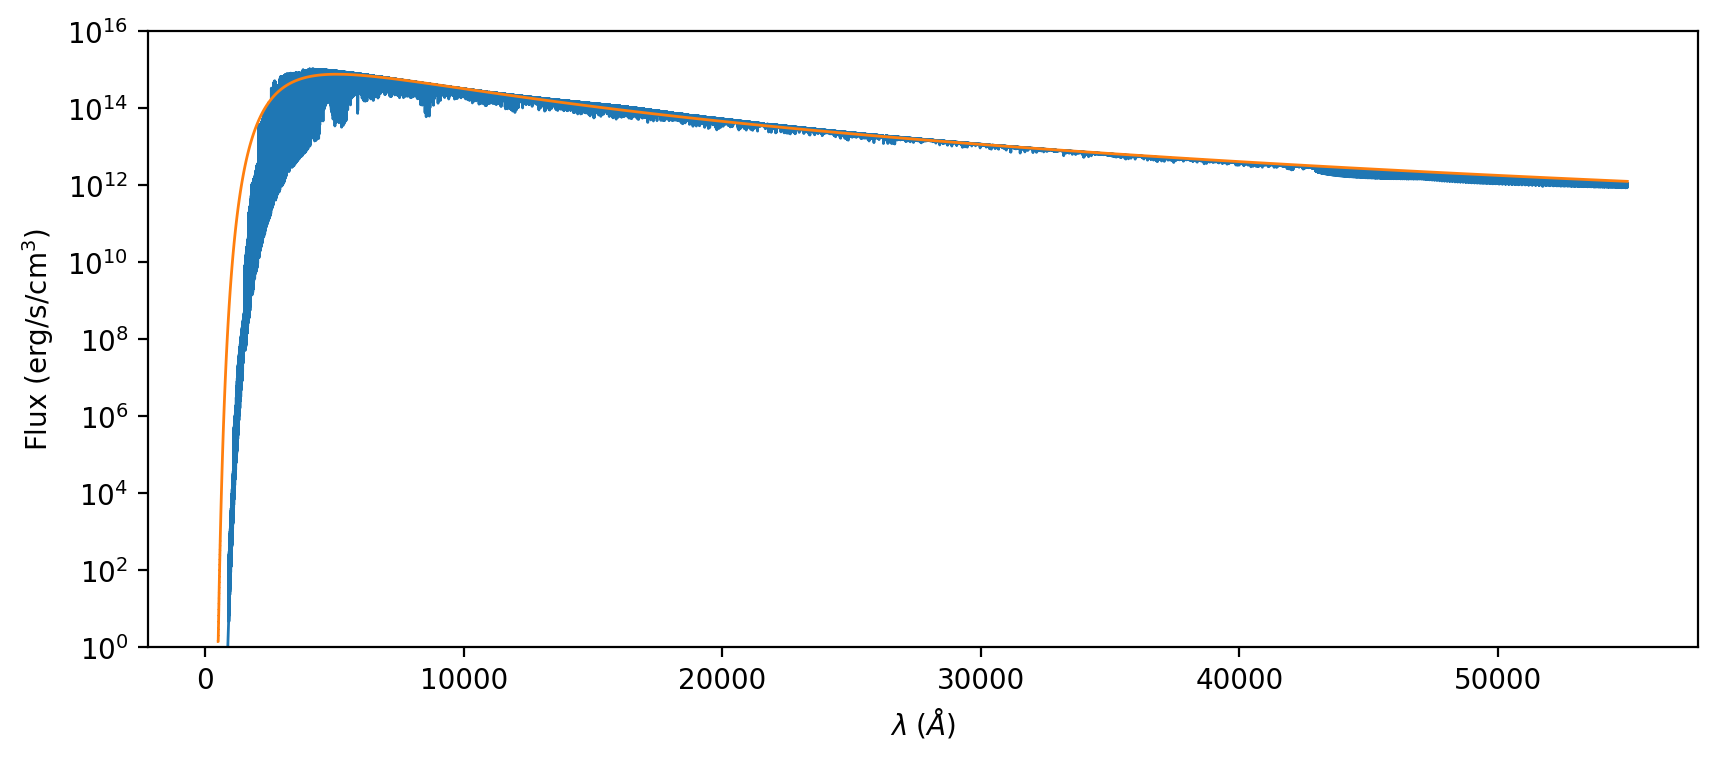

In [18]:
ax = original_spectrum.plot(ylo=1, yhi=1e16)
blackbody.plot(ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Flux (erg/s/cm$^3$)')
plt.show()

The plot spans 16 orders of magnitude-- a huge dynamic range!  Notice that the spectra have similar---but not identical---broadband spectral shapes. They should have the identical area under the curve, by the definition of effective temperature.  Let's see if they do!

In [11]:
from scipy.integrate import trapezoid

In [12]:
original_flux = trapezoid(original_spectrum.flux, x=original_spectrum.wavelength.to(u.cm))
black_body_flux = trapezoid(blackbody.flux, x=original_spectrum.wavelength.to(u.cm))

original_flux/black_body_flux

<Quantity 0.99048532>

The two spectral models have the same flux to within 1%, which is close enough to identical given that more spectrum resides outside the extent of the plot, and numerical artifacts limitations in the spectral modeling procedure.  Let's compute the ratio spectrum to see how flat the spectrum looks.  We'll first plot it over the same dynamic range as before to emphasize how much more compressed it is.

In [13]:
ratio_spectrum = original_spectrum.divide(blackbody)

The resulting spectrum is a ratio of fluxes with the same units, so it is dimensionless.

In [14]:
ratio_spectrum.flux.unit == u.dimensionless_unscaled

True

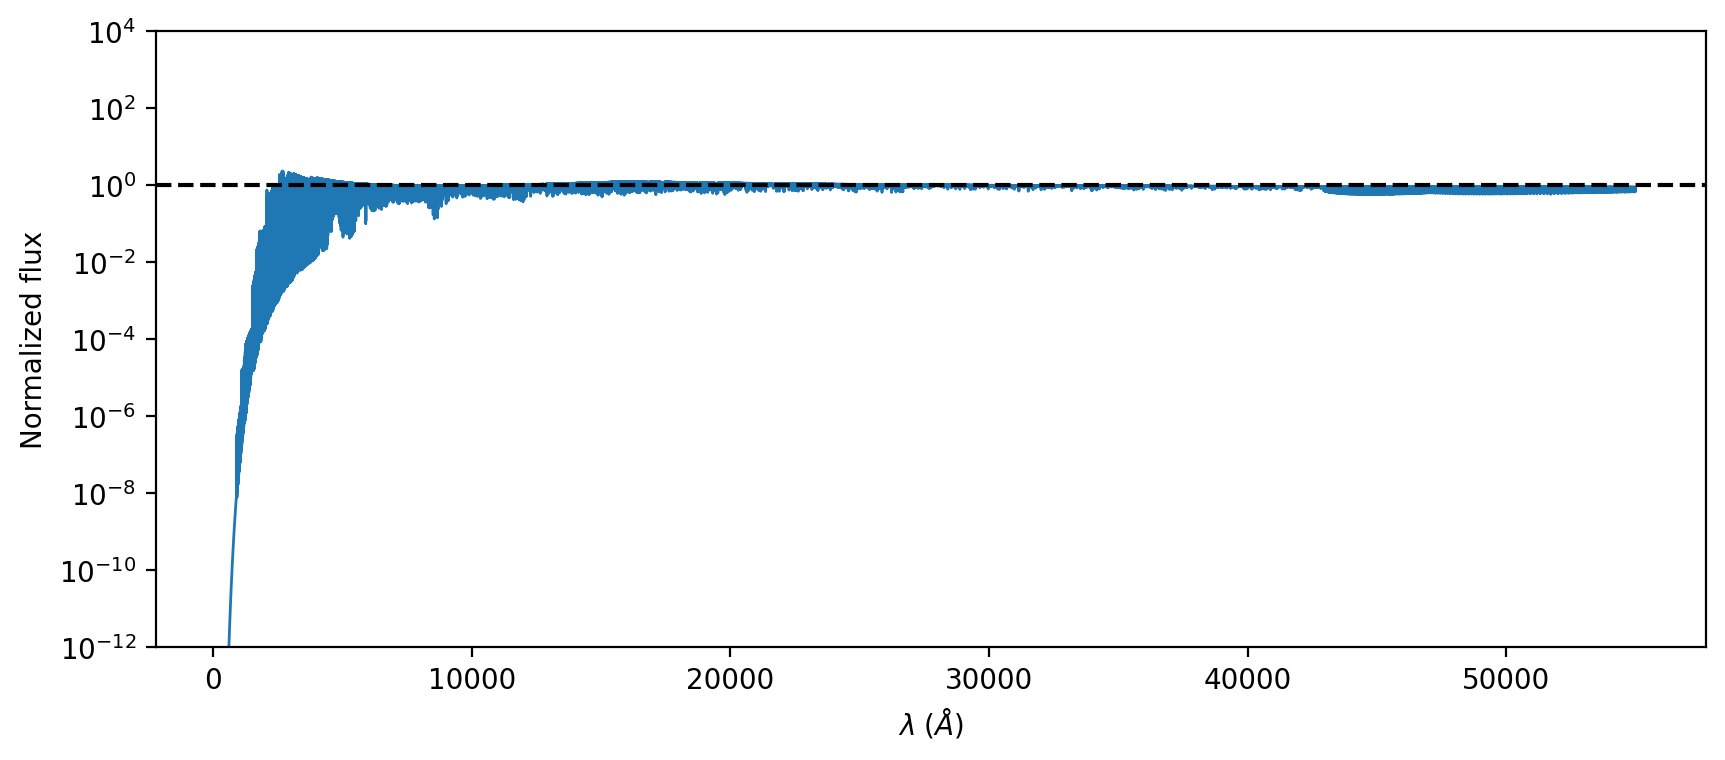

In [21]:
ax = ratio_spectrum.plot()
ax.set_ylim(1e-12, 1e4)
ax.set_yscale('log')
ax.set_ylabel('Normalized flux')
ax.axhline(1.0, linestyle='dashed', color='k')
plt.show()

At this dramatic zoom level, the flux looks pretty flat (except for the extreme ultraviolet portion of the spectrum).  Let's zoom in on a region of interest from $8000 - 13000\; Å$.

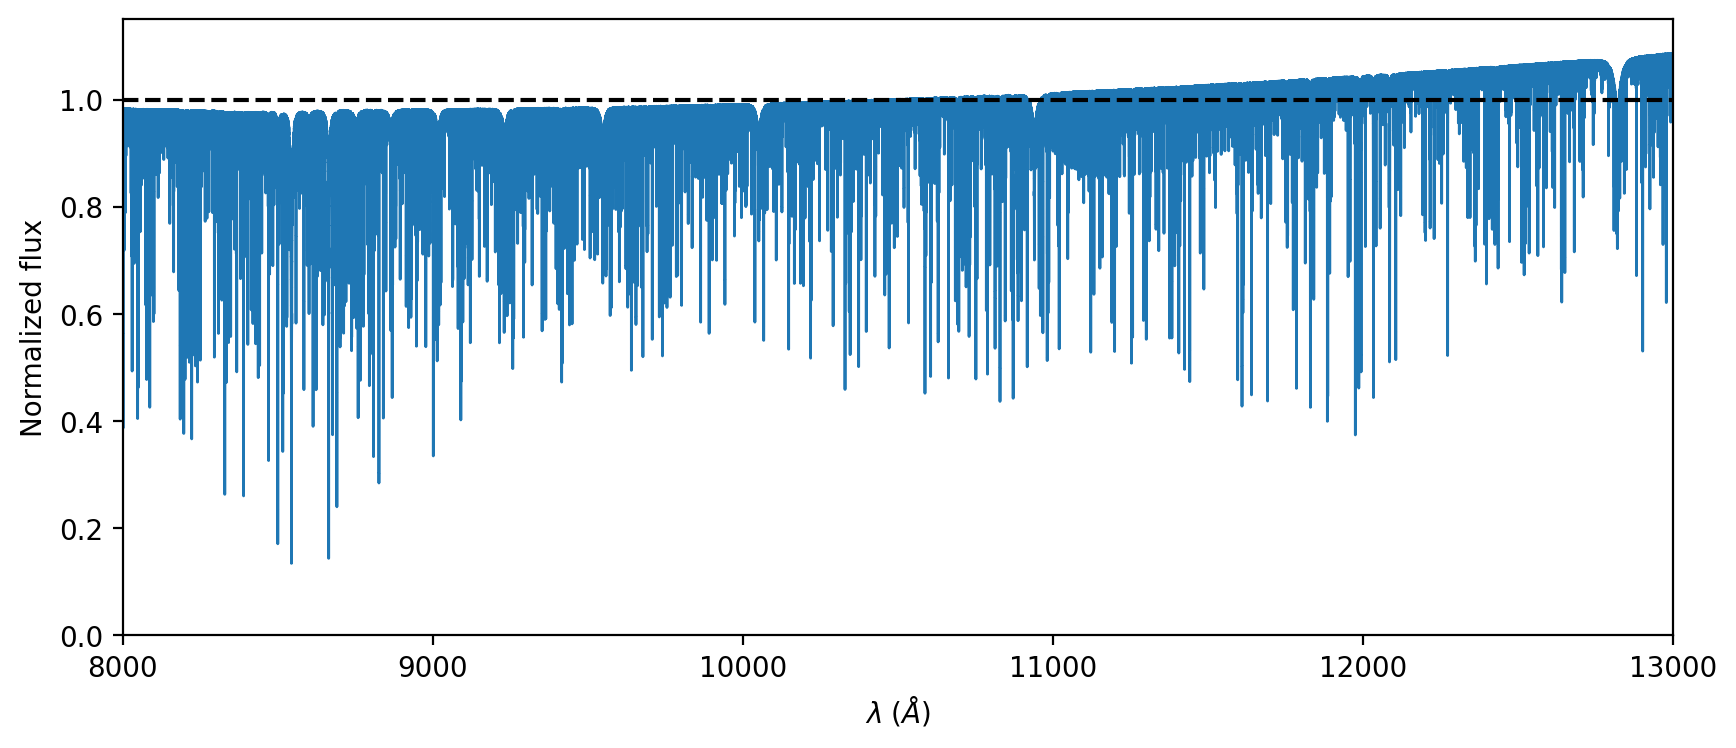

In [20]:
ax = ratio_spectrum.plot(ylo=0, yhi=1.15)
ax.set_ylabel('Normalized flux')
ax.axhline(1.0, linestyle='dashed', color='k')
ax.set_xlim(8_000, 13_000)
plt.show()

OK, looks good!  We have successfully used the blackbody curve to coarsely flatten the spectrum!